In [101]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import Video

plt.rcParams['animation.embed_limit'] = 2**128

<font size="5">**Punto 1**.</font>

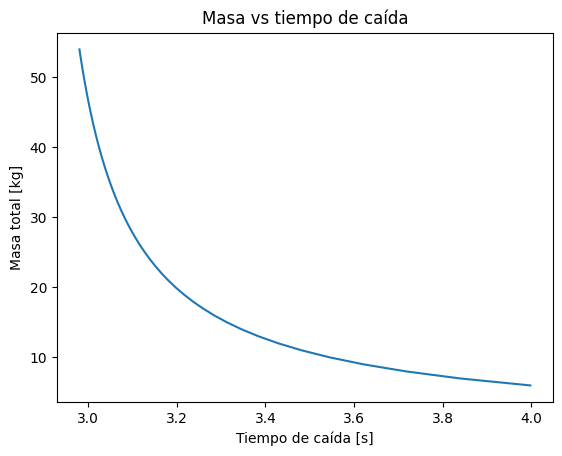

In [102]:
sin = np.sin
cos = np.cos

def system(t,y, theta, gamma, mass,h):
    g = 9.81
    x,v = y
    return [v, g*sin(theta) - (gamma/mass)*v**2] #La ecuación diferencial se resuelve con la coordenada del carro


def stop(t, y, theta,gamma,mass, h): #Definición función de parada
    x,v = y
    return x-h/sin(theta) #Para cuando: return=0
stop.terminal = True  #hace que se detenga
stop.direction = 1

#Condiciones del sistema
masas = np.arange(1,50,1)
theta = np.deg2rad(30)
h = 10
y0 = np.array([0.,0.])
t_span = (0,10) 
masa0 = 5
#Soluciones al sistema para distintas masas
j = 0
tiempos_caida = np.zeros(np.size(masas))
for i in masas:
    args = [theta, 0.7, masa0 + i,h] #ángulo theta, coeficiente gamma, la masa de cada carro y la altura.
    sol = solve_ivp(
        system, 
        y0=y0, 
        t_span=t_span, 
        args=args, 
        max_step=0.05,
        events=stop,
        dense_output=0
        )
    coord = np.array([cos(theta)*sol.y[0], sin(-theta)*sol.y[0]]) #Cambio de coordenadas a x,y
    coord[1,:] += h #ajuste de coordenadas
    if sol.t_events[0].size > 0:  # Para cuando está en y=0
        tiempo_caida = sol.t_events[0][0]
        tiempos_caida[j] = tiempo_caida
        j+=1

plt.ion()
plt.plot(tiempos_caida, masas+5) 
plt.title("Masa vs tiempo de caída")
plt.ylabel("Masa total [kg]")
plt.xlabel("Tiempo de caída [s]")
plt.show()

¿El tiempo de caída de los carros depende de la masa que llevan encima? De acuerdo con nuestro sistema y debido a la fricción líquida, sí depende el tiempo de caida de la masa total.

<font size="5">**Punto 2**.</font>

0.4666983500741617


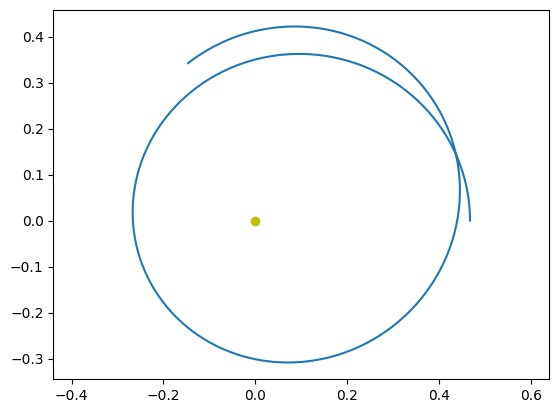

In [103]:
mu = 39.4234021 # GM
alpha = 1.09778201e-2 # 3(L/mc)^2
a = 0.38709893 #semieje mayor
e = 0.20563069 #excentricidad

#Posiciones iniciales
x0 = a*(1+e)
print(x0)
y0 = 0
r0 = np.array((x0, y0))

#velocidades iniciales
vx0 = 0
vy0 = np.sqrt((mu/a)*((1-e)/(1+e)))
vr0 = np.array((vx0, vy0))

#condiciones sistema
t_span=(0.,5.)
Y0 = np.hstack((r0, vr0)) #une r0, vr0 


def system(t, Y):
    x,y,vx,vy = Y
    r_vec = np.array([x, y]) #Vector (x,y)
    Ydot = np.array([vx,vy,0.,0.])
    r = np.linalg.norm(r_vec) #magnitud de r
    r_unitario = r_vec/r
    a_vec = -(mu/ r**2)*(1+(alpha/r**2))*r_unitario #ec diferencial
    Ydot[2] = a_vec[0]
    Ydot[3] = a_vec[1]
    return Ydot

def evento_vr_cero(t, Y):
    r_vec = Y[:2]  #Vector (x,y)
    v_vec = Y[2:]  #vector (vx, vy)
    return np.dot(r_vec, v_vec) #producto punto r*v

sol = solve_ivp(system,
                t_span=t_span, 
                y0=Y0,
                max_step=1e-3,
                dense_output=True
                )


#lejos_cerca = sol.y_events[0][:, :2]
#eventos_tiempos = sol.t_events[0]
r = np.array([sol.y[0],sol.y[1]])
v = np.array([sol.y[2],sol.y[3]]) 

#angles = np.arctan2(lejos_cerca[:,1], lejos_cerca[:,0]) # No se que sale mal en precesión (arctan2 da angulos entre [-pi, pi])
#for i in range(np.size(angles)):
#    if angles[i] < 0.:
#        angles[i] += 2*np.pi # cambia los ángulos <0 para que en total los ángulos queden entre [0, 2pi] 

#plt.plot(sol.t, v[0]**2 + v[1]**2 + mu/(np.sqrt(r[0]**2 + r[1]**2)) ) #Precesión (está mal :C)
#plt.title("Angulo vs tiempo")

#plt.show()
#plt.scatter(lejos_cerca[:,0], lejos_cerca[:,1], c="r", label="Puntos +cerca y +lejos")
plt.scatter(0,0, label="Sol", c="y")
plt.axis("equal")
plt.plot(r[0][:300], r[1][:300])
plt.show()


In [104]:
#ANIMACIÓN
plt.ioff()
t_dense = np.linspace(sol.t[0],sol.t[-2],1000)
Y_dense = sol.sol(t_dense)
x_dense,y_dense,vx_dense,vy_dense = Y_dense


fig = plt.figure()
ax = plt.axes()
ax.set_facecolor("black")
fig.patch.set_facecolor('black')
plt.xlim(x_dense.min()-0.5,x_dense.max()+0.5)
plt.ylim(y_dense.min()-0.5,y_dense.max()+0.5)

point = plt.scatter(*Y0[:2], color='white')
line = plt.plot(*Y0[:2], color='white')[0]
plt.scatter(0,0, s=100, c="yellow", label= "Sol")


# Línea semitransparente del cuarto anterior


def func(frame):
    # update scatter
    point.set_offsets(Y_dense[:2,frame])
    # update line
    if frame>1:
        line.set_data(x_dense[:frame+1],y_dense[:frame+1])
        
    
    return point,line
plt.title("Órbita", color='white')  # Título en blanco
anim = animation.FuncAnimation(fig,func,frames=range(len(t_dense)),interval=20)

anim.save('mercurio.mp4', writer='ffmpeg', savefig_kwargs=dict(facecolor='#000000')) #Guarda la animación, no funciona si no está instalado ffmpeg

In [105]:

Video("mercurio.mp4") #mercury es con alpha e-2, mercurio es con alpha e-8
